In [9]:
!pip install keras librosa noisereduce sklearn scikit-plot

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
from sklearn.model_selection import train_test_split
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
import librosa
from tqdm.autonotebook import tqdm
import noisereduce as nr
import matplotlib.pyplot as plt
from sklearn import metrics
import scikitplot as skplt
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import sklearn

In [0]:
def wav2mfcc(file_path, max_len=15, function=None):
    wave, sr = librosa.load(file_path, sr=16000, res_type='kaiser_fast')
    #yrn = nr.reduce_noise(audio_clip=wave, noise_clip=wave, verbose=False)
    yf, index = librosa.effects.trim(wave,top_db=30)
    
    if function != None:
        mfcc = librosa.feature.mfcc(y=function(yf), sr=16000, hop_length=1024, htk=True, n_mfcc=13)
    else:
        mfcc = librosa.feature.mfcc(y=yf, sr=16000, hop_length=1024, htk=True, n_mfcc=13)
   #mfcc_delta = librosa.feature.delta(mfcc,mode='nearest')
    #mfcc_delta2 = librosa.feature.delta(mfcc, order=2,mode='nearest')
    
    #mfcc = np.concatenate((mfcc, mfcc_delta,mfcc_delta2))
    #max_len = max_len *3
    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        a,b=0,0
        if pad_width % 2 == 0:
            a = pad_width//2
            b = pad_width//2
        else:
            a = pad_width//2
            b = pad_width//2 +1
        mfcc = np.pad(mfcc, pad_width=((0, 0), (a, b)), mode='constant')
        #mfcc_delta = np.pad(mfcc_delta, pad_width=((0, 0), (a, b)), mode='constant')
        #mfcc_delta2 = np.pad(mfcc_delta2, pad_width=((0, 0), (a, b)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
        #mfcc_delta = mfcc_delta[:, :max_len]
        #mfcc_delta2 = mfcc_delta2[:, :max_len]
    #mfcc = np.concatenate((mfcc, mfcc_delta,mfcc_delta2))
    return mfcc

In [0]:
def save_data_to_array(path,to,labels, max_len=60):
    dataset = getDataset(path,labels)
    print(np.sum([len(i) for i in dataset]))
    folder = to
    for i,data in enumerate(dataset):
        # Init mfcc vectors
        mfcc_vectors = []
        for wavfile in data:
            mfcc = wav2mfcc(path + wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
        np.save(folder + labels[i] + '.npy', mfcc_vectors)

In [0]:
def getDataset(path,labels):
    audioFiles = np.array(os.listdir(path))
    dataset = [
        audioFiles[np.char.find(audioFiles,name) == 4] for name in labels
    ]
    return dataset

In [0]:
def get_train_test(paths,labels, split_ratio=0.6, random_state=42):

    X_train, X_test, Y_train, Y_test = ([],[],[],[])
    for path in paths:
        ## PATH_DATA_WITHOUT_NOISE
        # Getting first arrays
        X = np.load(path+labels[0] + '.npy')
        y = np.zeros(X.shape[0])

        # Append all of the dataset into one single array, same goes for y
        for i, label in enumerate(labels[1:]):
            x = np.load(path + label + '.npy')
            X = np.vstack((X, x))
            y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

        assert X.shape[0] == len(y)
        
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)
        X_train.extend(x_train)
        X_test.extend(x_test)
        Y_train.extend(y_train)
        Y_test.extend(y_test)
    return (np.array(X_train), np.array(X_test), Y_train, Y_test)


In [0]:
!mkdir /tmp/corpus

In [0]:
!cp -r /content/drive/My\ Drive/ups/sc/corpus/* /tmp/corpus

In [0]:
labels = ["tournegauche","tournedroite","recule","plushaut","plusbas","gauche","faisunflip","etatdurgence","droite","decollage","avance","atterrissage","arretetoi"]


In [0]:
folders = os.listdir('/tmp/corpus/')

In [0]:
os.mkdir('/tmp/data2')
for folder in folders:
    os.mkdir("/tmp/data2/"+folder)

In [25]:
for path in folders:
  print(path)
  save_data_to_array("/tmp/corpus/"+path+"/","/tmp/data/"+path+"/",labels)

hauteur_plus_25%
234
drone_withoutnoise
234
hauteur_plus_50%
234
drone_noise
52
hauteur_moins_15%
234
hauteur_plus_15%
234
hauteur_moins_25%
234
hauteur_moins_50%
234


In [0]:
!mkdir /content/drive/My\ Drive/ups/sc/corpus/data2
!cp -r /tmp/data2/* /content/drive/My\ Drive/ups/sc/corpus/data2/ 

In [0]:
X_train, X_test, y_train, y_test = get_train_test(["/tmp/data/"+folder+"/" for folder in folders],labels,0.8)

In [29]:
X_train.shape

(976, 13, 60)

In [0]:
feature_dim_2 = 60
feature_dim_1 = 13
channel = 1
epochs = 50
batch_size = 500
verbose = 1
num_classes = len(labels)

# Reshaping to perform 2D convolution
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [0]:
def get_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(GlobalAveragePooling2D(name='avg_pool'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

# Predicts one sample
def predict(filepath, model):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    return get_labels()[0][
            np.argmax(model.predict(sample_reshaped))
    ]

In [0]:
os.mkdir('/content/drive/My Drive/ups/sc/corpus/logs')

In [0]:
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/ups/sc/corpus/logs/checkpoint-inceptionresnetv2-v1-get-{epoch:02d}-{val_acc:.4f}.hdf5',monitor='val_acc', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-9, verbose=1)


In [37]:
model = get_model()

In [39]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 12, 59, 32)        160       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 58, 48)        6192      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 29, 48)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 29, 48)         0         
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 48)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               6272      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

In [0]:
model.fit(X_train, y_train_hot, batch_size=210, epochs=1500, verbose=verbose, 
          validation_data=(X_test, y_test_hot),callbacks=[model_checkpoint])

In [0]:
acc = []
loss = []
val_loss = []
val_acc = []
for h in [hist,hist2,hist3,hist4]:
  acc.extend(h['acc'])
  loss.extend(h['loss'])
  val_loss.extend(h['val_loss'])
  val_acc.extend(h['val_acc'])

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


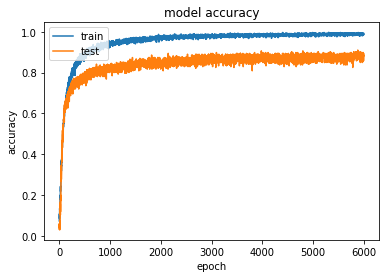

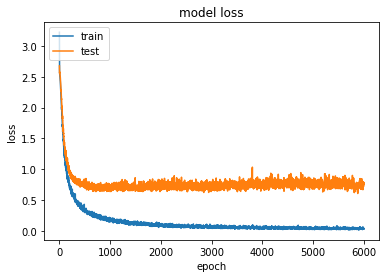

In [57]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


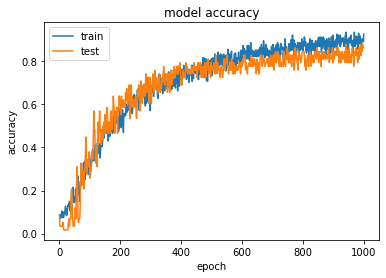

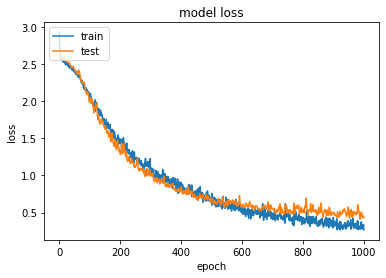

In [0]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
np.max(model.history.history['val_accuracy'])

0.8793103694915771

In [0]:
def plot_eval(y_test, y_pred):
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True,figsize=(10,10))
    plt.show()
    print(sklearn.metrics.classification_report(y_test, y_pred,digits=2))

In [0]:
model.load_weights('/content/drive/My Drive/ups/sc/corpus/logs/checkpoint-inceptionresnetv2-v1-get-1384-0.9106.hdf5')

In [0]:
y_pred=model.predict_classes(X_test)

In [60]:
X_test.shape

(246, 13, 60, 1)

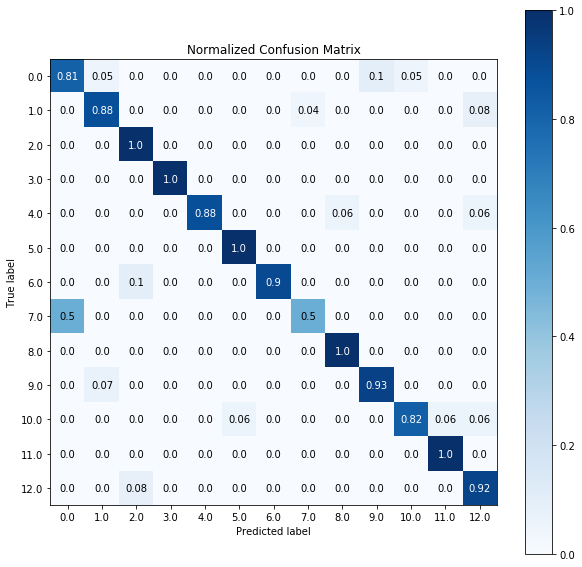

              precision    recall  f1-score   support

         0.0       0.77      0.81      0.79        21
         1.0       0.92      0.88      0.90        26
         2.0       0.56      1.00      0.71         5
         3.0       1.00      1.00      1.00        22
         4.0       1.00      0.88      0.94        17
         5.0       0.91      1.00      0.95        10
         6.0       1.00      0.90      0.95        20
         7.0       0.83      0.50      0.62        10
         8.0       0.96      1.00      0.98        26
         9.0       0.88      0.93      0.90        15
        10.0       0.93      0.82      0.87        17
        11.0       0.97      1.00      0.98        31
        12.0       0.86      0.92      0.89        26

    accuracy                           0.91       246
   macro avg       0.89      0.90      0.88       246
weighted avg       0.92      0.91      0.91       246



In [63]:
plot_eval(y_test, y_pred)

In [64]:
y_predk=[]
y_true=[]
for file in os.listdir("/content/drive/My Drive/ups/sc/own_drone_commands"):
    sample_class=file.split('_')[1]   
    #print(file)
    y_true.append(labels.index(sample_class[:(len(sample_class)-4)]))
    mfcc_thang = wav2mfcc('/content/drive/My Drive/ups/sc/own_drone_commands/'+file,max_len=60)
    y_pred=model.predict([mfcc_thang.reshape(1,feature_dim_1, feature_dim_2, 1)])
    print(file, labels[np.argmax(y_pred)], np.max(y_pred))
    y_predk.append(np.argmax(y_pred))

MC1_faisunflip.wav arretetoi 0.6609021
C01_faisunflip.wav faisunflip 0.7447146
C01_droite.wav plusbas 0.6734557
C02_tournegauche.wav tournegauche 0.99999106
MC1_gauche.wav tournegauche 0.882857
MC1_etatdurgence.wav etatdurgence 0.999984
C02_atterrissage.wav atterrissage 0.98026705
C01_plushaut.wav plushaut 0.9340228
C01_arretetoi.wav arretetoi 0.97797465
MC1_tournedroite.wav tournedroite 0.99999774
C02_recule.wav recule 0.76050276
C01_gauche.wav gauche 0.99101907
C02_faisunflip.wav tournedroite 0.99589694
MC1_decollage.wav decollage 0.99988806
C02_arretetoi.wav arretetoi 0.99911934
MC1_plusbas.wav plusbas 0.9997814
MC1_atterrissage.wav atterrissage 0.9273623
C02_etatdurgence.wav etatdurgence 1.0
C02_avance.wav avance 0.9999999
C02_tournedroite.wav tournedroite 0.99999344
MC1_tournegauche.wav tournegauche 0.79056567
MC1_droite.wav tournedroite 0.6355561
C02_decollage.wav decollage 1.0
C01_avance.wav avance 1.0
C01_etatdurgence.wav etatdurgence 0.9999833
C01_plusbas.wav plusbas 0.9696737

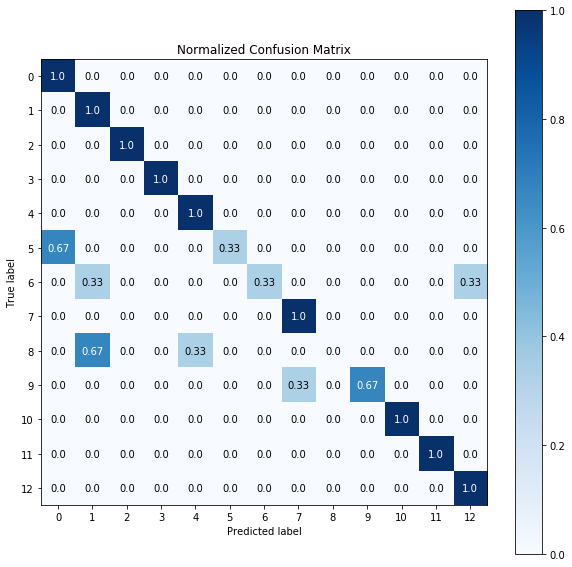

              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.50      1.00      0.67         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       0.75      1.00      0.86         3
           5       1.00      0.33      0.50         3
           6       1.00      0.33      0.50         3
           7       0.75      1.00      0.86         3
           8       0.00      0.00      0.00         3
           9       1.00      0.67      0.80         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       0.75      1.00      0.86         3

    accuracy                           0.79        39
   macro avg       0.80      0.79      0.75        39
weighted avg       0.80      0.79      0.75        39



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [65]:
plot_eval(y_true, y_predk)